#Preliminary operations

##Import libraries

In [ ]:
#import main libraries
!pip install pyclustering
!pip install -U scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.6 MB 5.3 MB/s 
  Created wheel for pyclustering: filename=pyclustering-0.10.1.2-py3-none-any.whl size=2395121 sha256=f72b38610e101635852c332f0e9352a1cdf1e10bc8f380b952276c36a676418e
  Stored in directory: /root/.cache/pip/wheels/ea/87/6b/1e0568b5ba9dc6518a25338bae90bd8392f35206bb90bb10f1
Successfully built pyclustering
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# import main libraries
#!pip install pyclustering
#!pip install -U scikit-learn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from pyclustering.cluster import xmeans
import sklearn

In [ ]:
# stats
from scipy import stats
#scaling, normalization
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# kmeans, dbscan, hierarchical (sklearn)
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
# evaluation
from sklearn.metrics import silhouette_score
# distance matrix (dbscan elbow, hierarchical)
from scipy.spatial.distance import pdist, squareform
# hierarchical (scipy)
from scipy.cluster.hierarchy import linkage, dendrogram
# Principal Component Analysis
from sklearn.decomposition import PCA
from sklearn.metrics.cluster import rand_score
from sklearn.metrics.cluster import adjusted_rand_score

##Mount Google Drive

In [ ]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Import datasets

In [ ]:
# import dataframe (without outliers)
df = pd.read_excel("drive/MyDrive/Progetto Data Mining 1/Data Understanding & Preparation/Data prepared final/df_prep_final.xlsx", index_col="Unnamed: 0")
df_emph_high = pd.read_excel("drive/MyDrive/Progetto Data Mining 1/Data Understanding & Preparation/Data prepared final/df_prep_final_emph_high.xlsx", index_col="Unnamed: 0")
df_emph_low = pd.read_excel("drive/MyDrive/Progetto Data Mining 1/Data Understanding & Preparation/Data prepared final/df_prep_final_emph_low.xlsx", index_col="Unnamed: 0")

In [ ]:
# get data columns
df_data = df[["stft_mean", "mfcc_mean", "skew"]]
df_data_emph_high = df_emph_high[["stft_mean", "mfcc_mean", "skew"]]
df_data_emph_low = df_emph_low[["stft_mean", "mfcc_mean", "skew"]]

# get values from data columns
X = df_data.values
X_emph_high = df_data_emph_high.values
X_emph_low = df_data_emph_low.values

# get emotion lables from each emphasis group
y_emotion = df["emotion"]
y_emotion_emph_high = df_emph_high["emotion"]
y_emotion_emph_low = df_emph_low["emotion"]

# get emotion type from each emphasis group
y_emtype = df["emotion_type"]
y_emtype_emph_high = df_emph_high["emotion_type"]
y_emtype_emph_low = df_emph_low["emotion_type"]

In [ ]:
# get data columns
df_data = df.loc[:, "length_ms":"skew"]
df_data_emph_high = df_emph_high.loc[:, "length_ms":"skew"]
df_data_emph_low = df_emph_low.loc[:, "length_ms":"skew"]

# get values from data columns
X = df_data.values
X_emph_high = df_data_emph_high.values
X_emph_low = df_data_emph_low.values

# get emotion lables from each emphasis group
y_emotion = df["emotion"]
y_emotion_emph_high = df_emph_high["emotion"]
y_emotion_emph_low = df_emph_low["emotion"]

# get emotion type from each emphasis group
y_emtype = df["emotion_type"]
y_emtype_emph_high = df_emph_high["emotion_type"]
y_emtype_emph_low = df_emph_low["emotion_type"]

##Normalization

In [ ]:
# get StandardScaler
std_scaler = StandardScaler()

# normalise each emphasis group with StandardScaler
X_std = std_scaler.fit_transform(X)
X_std_emph_high = std_scaler.fit_transform(X_emph_high)
X_std_emph_low = std_scaler.fit_transform(X_emph_low)

# get MinMaxScaler
mima_scaler = MinMaxScaler()

# normalise each emphasis group with MinMaxScaler
X_mima = mima_scaler.fit_transform(X)
X_mima_emph_high = mima_scaler.fit_transform(X_emph_high)
X_mima_emph_low = mima_scaler.fit_transform(X_emph_low)

#PCA

In [ ]:
# get PCA
pca = PCA(n_components=3)
model = pca.fit(X_std)
# run PCA
X_pc = model.transform(X_std)

# get the number of components
n_pcs= model.components_.shape[0]

# get the index of the most important feature on EACH component
most_important = [np.abs(model.components_[i]).argmax() for i in range(n_pcs)]
initial_feature_names = df_data.columns
# get the names
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]

dic = {'PC{}'.format(i): most_important_names[i] for i in range(n_pcs)}

# build the dataframe
df_pca = pd.DataFrame(dic.items())
print(df_pca)

     0          1
0  PC0  stft_mean
1  PC1  mfcc_mean
2  PC2       skew


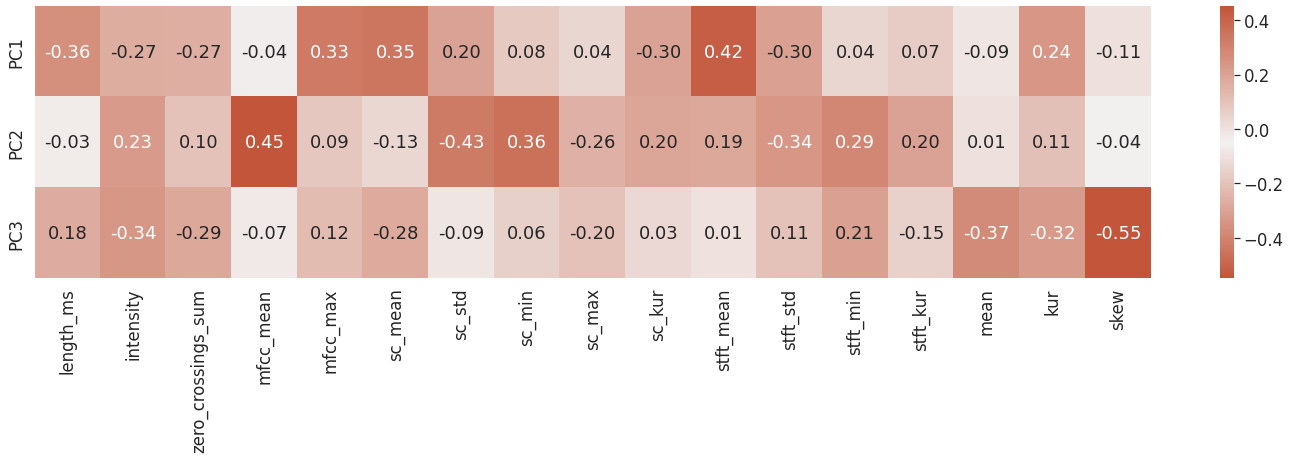

In [ ]:
plt.figure(figsize=(25,5))
sns.set_theme(font_scale=1.5)
cmap = sns.diverging_palette(20, 20, as_cmap=True)
sns.heatmap(model.components_, annot=True, xticklabels=df_data.columns, yticklabels=["PC1", "PC2", "PC3"], fmt=".2f", cmap=cmap)
plt.savefig("PCA.svg", format="svg")

#KMeans

##Choose number of clusters

###Silhouette

In [ ]:
sil_list = []

# iterate number of centroids
for k in range(2, 17):
  # get KMeans
  kmeans = KMeans(n_clusters=k, n_init=100, max_iter=3000, random_state=1)
  # fit KMeans
  kmeans.fit(X_std)
  # get silhouette score
  sil_score = silhouette_score(X_std, kmeans.labels_)
  print(str(k) + " " + str(sil_score))

  sil_list.append(sil_score)

2 0.278919498691772
3 0.30129478028987144
4 0.2867491561815956
5 0.2603064328990139
6 0.25473719252062865
7 0.2544487561388909
8 0.26093780196354177
9 0.2614915335242399
10 0.2593138069306869
11 0.2547249493892714
12 0.2542608750298307
13 0.24758838897325122
14 0.246207332628427
15 0.24461955150888443
16 0.24759250149885204


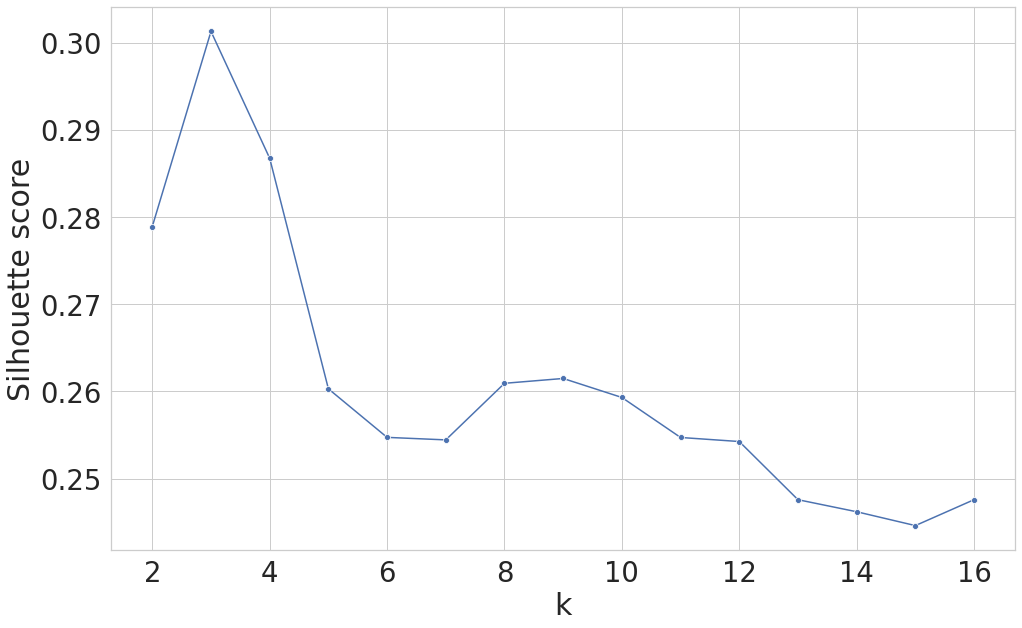

In [ ]:
# get silhouette score scatterplot
plt.figure(figsize=(16.2,10))
sns.lineplot(x=range(2, 17, 1), y=sil_list, marker='o')
plt.ylabel('Silhouette score')
plt.xlabel('k')
plt.savefig("silhouette_kmeans.svg", format="svg")
plt.show()

###SSE

In [ ]:
sse_list = []

# iterate number of centroids
for k in range(2, 17):
    # get KMeans
    kmeans = KMeans(n_clusters=k, n_init=10, max_iter=100)
    # fit KMeans
    kmeans.fit(X_std)
    # get SSE score
    sse_score = kmeans.inertia_
    print(str(k) + " " + str(sse_score))
    
    sse_list.append(kmeans.inertia_)

2 5129.396628252659
3 3652.636843107131
4 3109.6106191415583
5 2741.165823951701
6 2433.520940869095
7 2184.650794632074
8 1987.6164628558913
9 1840.9868570830445
10 1711.0046755822932
11 1610.014147514954
12 1528.6084169695182
13 1453.0068675126172
14 1394.5075997667739
15 1345.5338027963403
16 1282.4032600615842


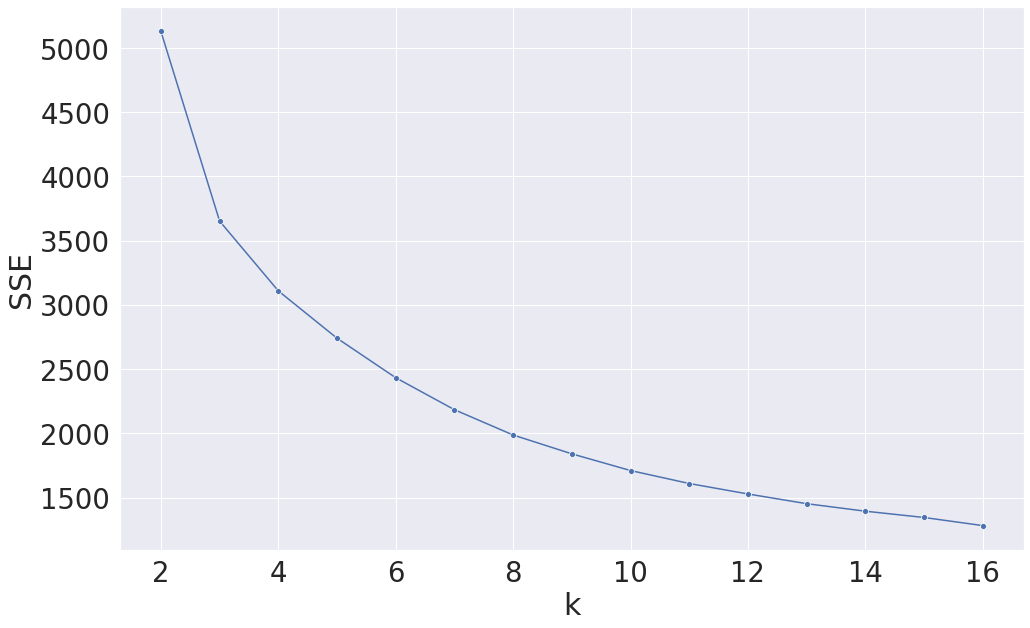

In [ ]:
# get SSE curve scatterplot
plt.figure(figsize=(16.2,10))
sns.set_theme(font_scale=2.5)
sns.lineplot(x=range(2, 17, 1), y=sse_list, marker='o')
plt.ylabel('SSE')
plt.xlabel('k')
plt.savefig("SSE_kmeans.svg", format="svg")
plt.show()

## All emphasis

In [ ]:
# get KMeans
kmeans = KMeans(n_clusters=4, n_init=100, max_iter=3000, random_state=1)
# fit KMeans
kmeans.fit(X_std)

KMeans(max_iter=3000, n_clusters=4, n_init=100, random_state=1)

Text(0.5, 1.0, 'KMeans clustering')

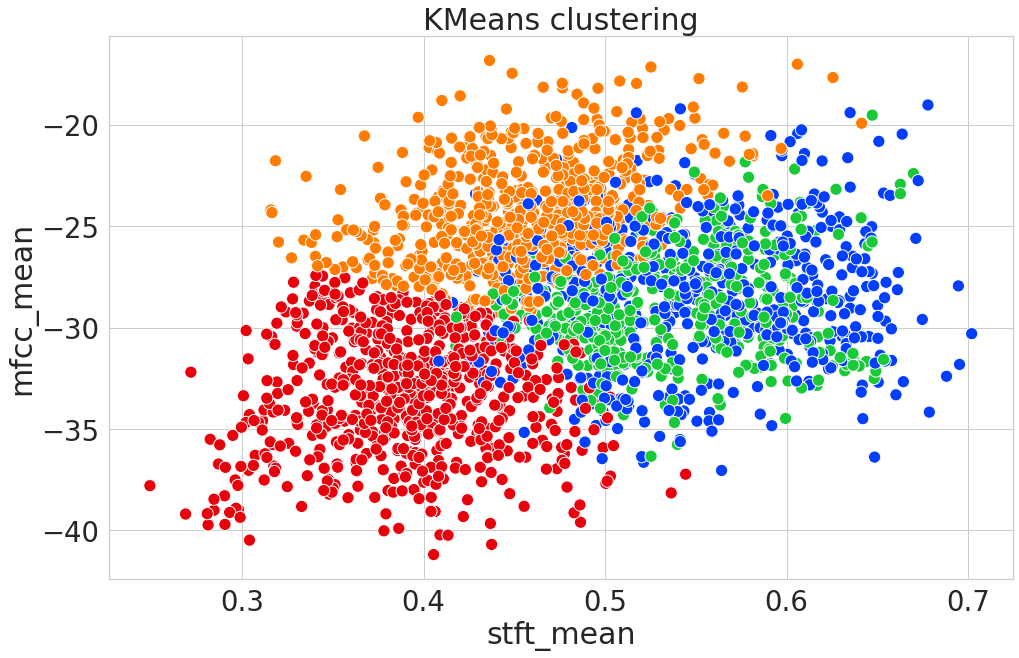

In [ ]:
# Set figure size with matplotlib
plt.figure(figsize=(16.2,10))
sns.set_theme(font_scale=2.5)
sns.set_style("whitegrid")
# Create plot
sns.scatterplot(
    data=df, 
    x="stft_mean", 
    y="mfcc_mean", 
    hue=kmeans.labels_,
    palette="bright",
    marker="o",
    s=150,
    legend=False
)
# Set title with matplotlib
plt.title('KMeans clustering')

In [ ]:
centers = kmeans.cluster_centers_
std_scaler.fit(X)
centers = std_scaler.inverse_transform(centers)

In [ ]:
df_data['kmeans_labels'] = kmeans.labels_

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


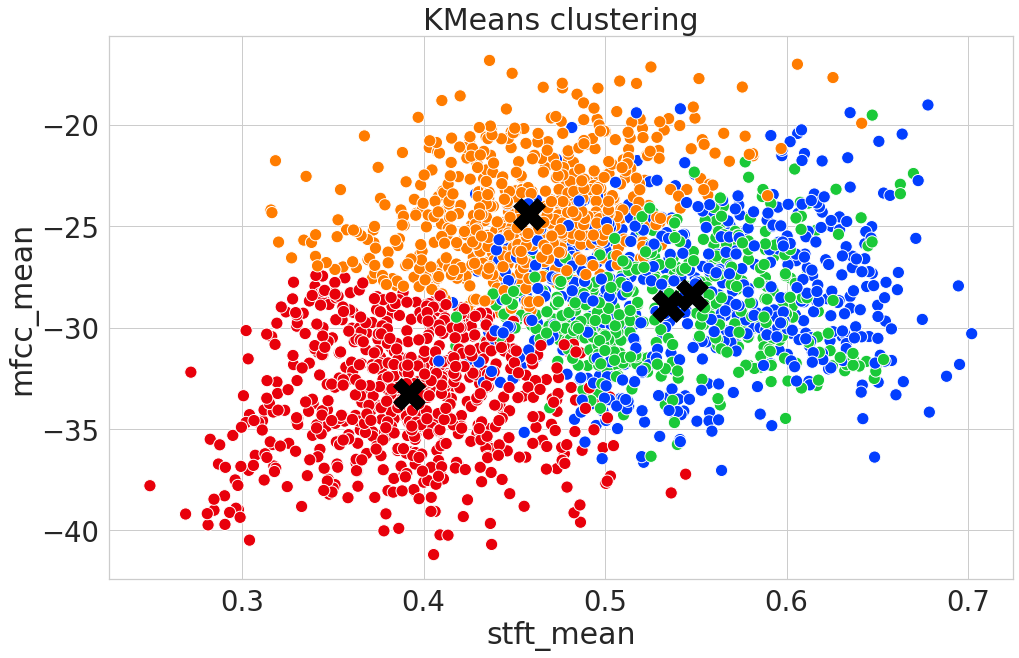

In [ ]:
# Set figure size with matplotlib
plt.figure(figsize=(16.2,10))
sns.set_theme(font_scale=2.5)
sns.set_style("whitegrid")
# Create plot
sns.scatterplot(
    data=df, 
    x="stft_mean", 
    y="mfcc_mean", 
    hue=kmeans.labels_,
    palette="bright",
    marker="o",
    s=150,
    legend=False
)
 
# Set title with matplotlib
plt.title('KMeans clustering')
plt.scatter(centers[:,0], centers[:,1], c='black', marker='X', s=1000)
plt.savefig("kmeans_all.svg", format="svg")
plt.show()

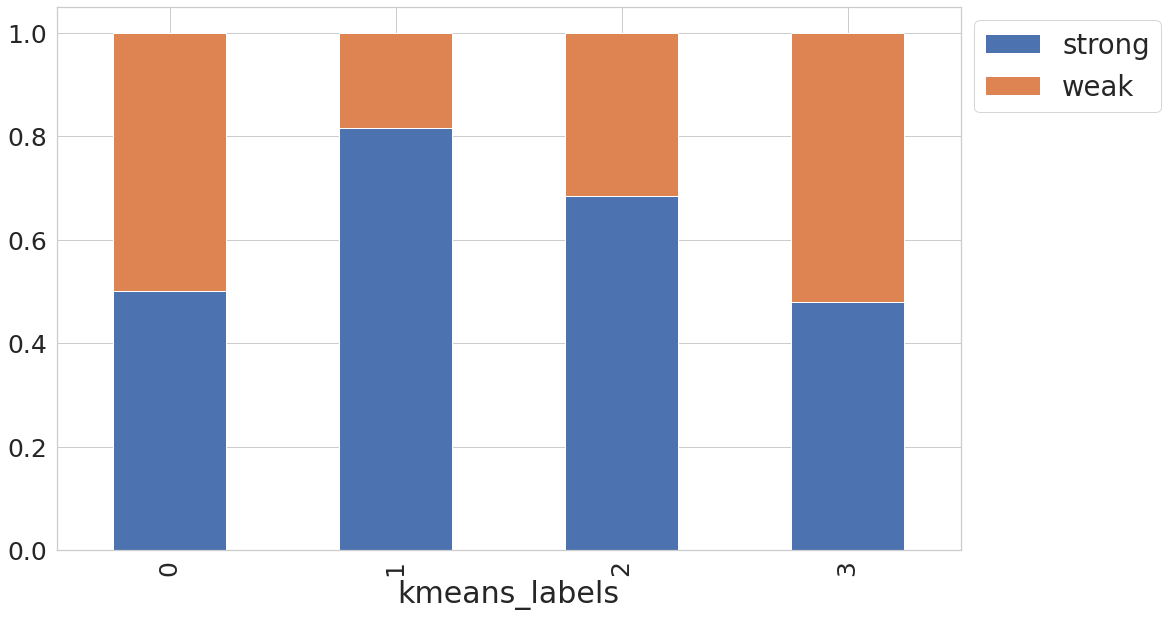

In [ ]:
bar_pl = y_emtype.groupby(df_data['kmeans_labels']).value_counts(normalize=True).unstack(1)

bar_pl.plot(kind='bar', stacked=True, edgecolor='white', fontsize=25, figsize=(16.2,10))
plt.legend(bbox_to_anchor=(1,1))
plt.savefig("emtype_kmeans_all.svg", format="svg")
plt.show()

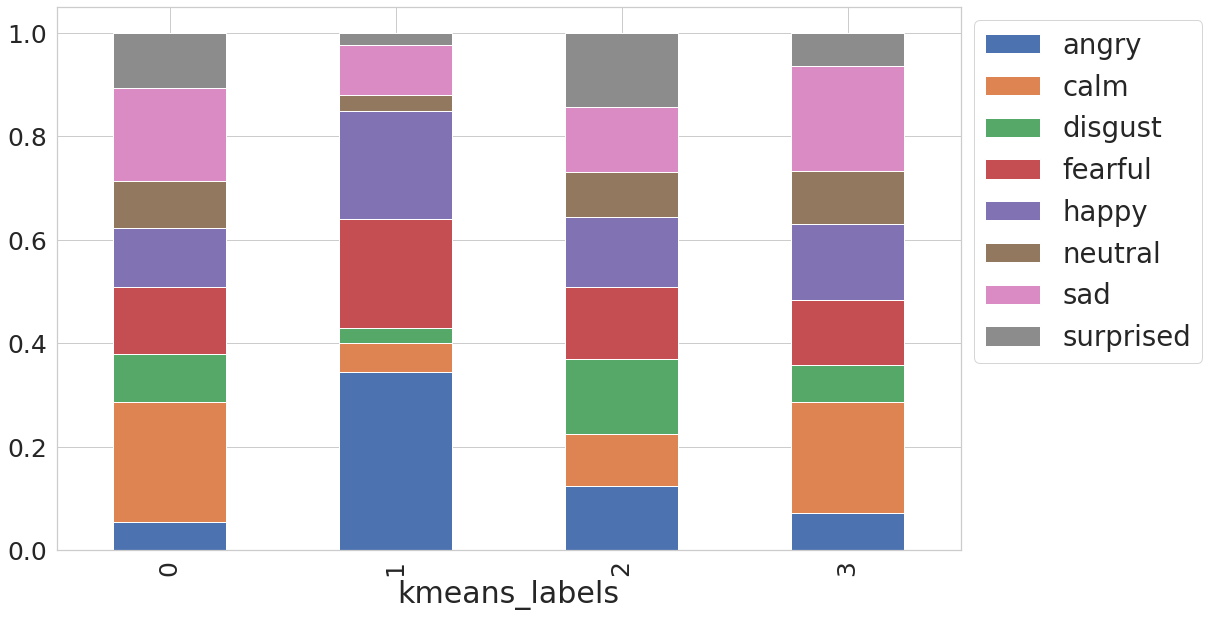

In [ ]:
bar_pl = y_emotion.groupby(df_data['kmeans_labels']).value_counts(normalize=True).unstack(1)
bar_pl.plot(kind='bar', stacked=True, edgecolor='white', fontsize=25, figsize=(16.2,10))

plt.legend(bbox_to_anchor=(1,1))
plt.savefig("emotions_kmeans_all.svg", format="svg")
plt.show()

## High emphasis

In [ ]:
# get KMeans
kmeans = KMeans(n_clusters=4, n_init=100, max_iter=3000, random_state=1)
# fit KMeans
kmeans.fit(X_std_emph_high)

KMeans(max_iter=3000, n_clusters=4, n_init=100, random_state=1)

Text(0.5, 1.0, 'KMeans clustering')

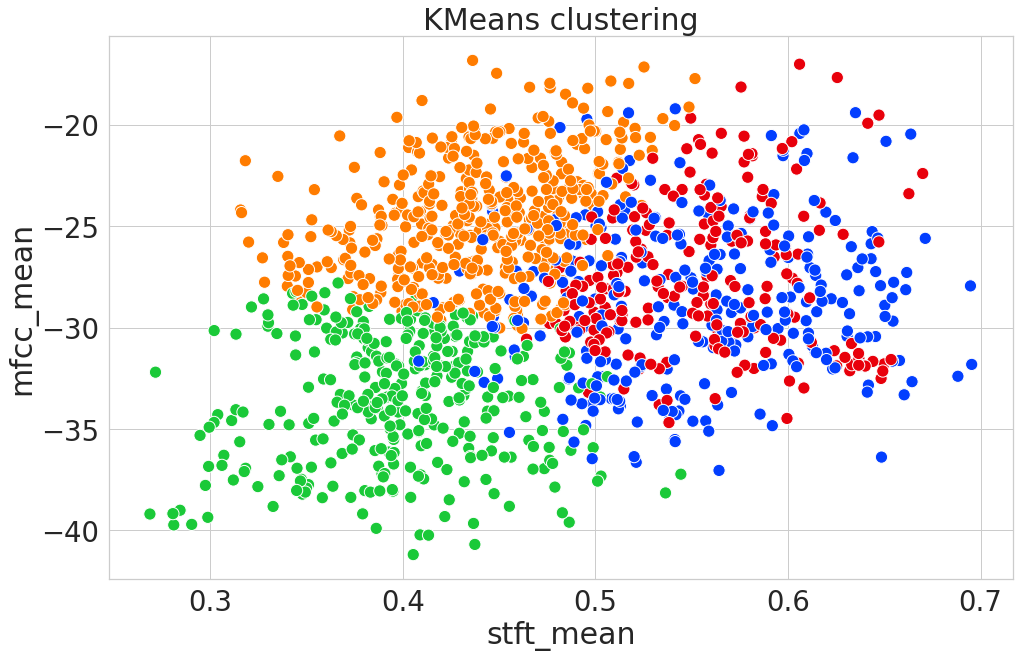

In [ ]:
# Set figure size with matplotlib
plt.figure(figsize=(16.2,10))
sns.set_theme(font_scale=2.5)
sns.set_style("whitegrid")
# Create plot
sns.scatterplot(
    data=df_emph_high, 
    x="stft_mean", 
    y="mfcc_mean", 
    hue=kmeans.labels_,
    palette="bright",
    marker="o",
    s=150,
    legend=False
)
# Set title with matplotlib
plt.title('KMeans clustering')

In [ ]:
centers = kmeans.cluster_centers_
std_scaler.fit(X_emph_high)
centers = std_scaler.inverse_transform(centers)

In [ ]:
df_data_emph_high['kmeans_labels'] = kmeans.labels_

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


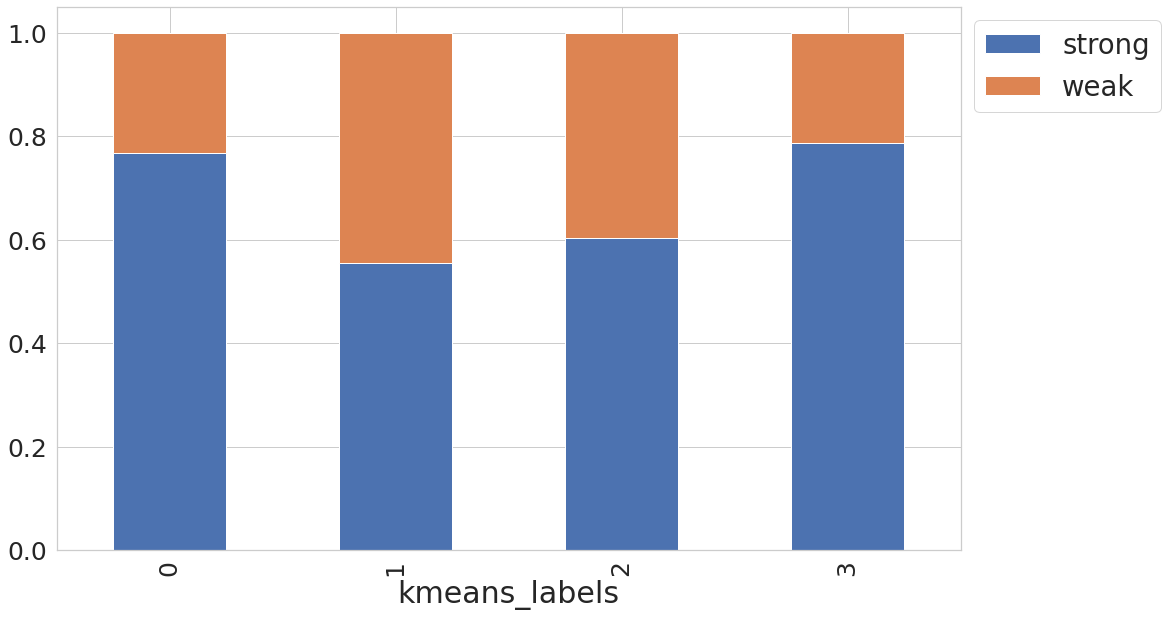

In [ ]:
bar_pl = y_emtype_emph_low.groupby(df_data_emph_low['kmeans_labels']).value_counts(normalize=True).unstack(1)

bar_pl.plot(kind='bar', stacked=True, edgecolor='white', fontsize=25, figsize=(16.2,10))
plt.legend(bbox_to_anchor=(1,1))
plt.savefig("emtype_kmeans_emph_low.svg", format="svg")
plt.show()

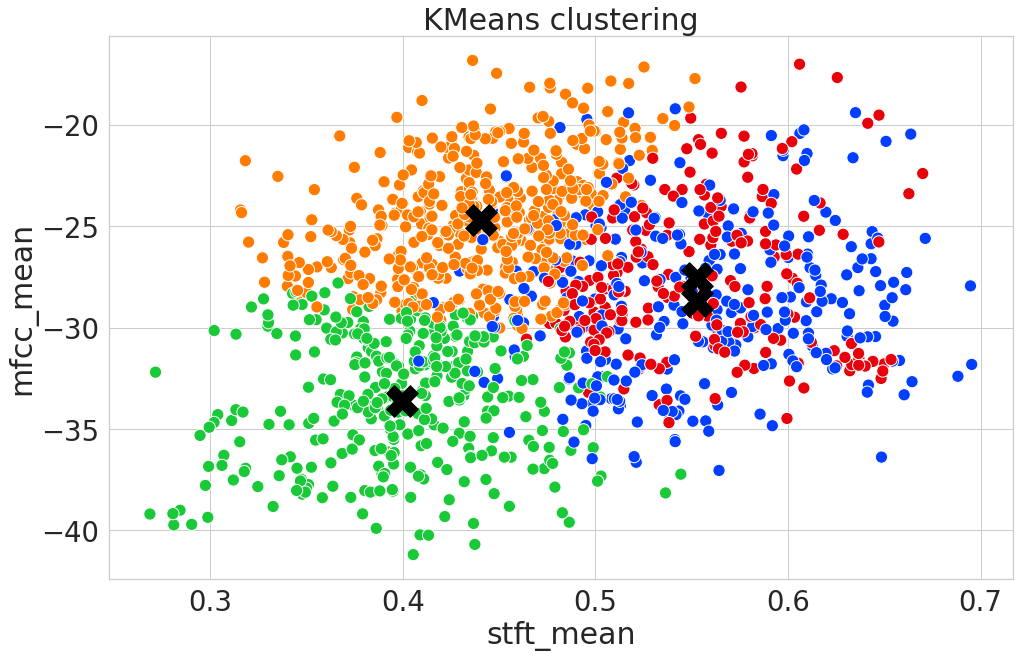

In [ ]:
# Set figure size with matplotlib
plt.figure(figsize=(16.2,10))
sns.set_theme(font_scale=2.5)
sns.set_style("whitegrid")
# Create plot
sns.scatterplot(
    data=df_emph_high, 
    x="stft_mean", 
    y="mfcc_mean", 
    hue=kmeans.labels_,
    palette="bright",
    marker="o",
    s=150,
    legend=False
)
 
# Set title with matplotlib
plt.title('KMeans clustering')
plt.scatter(centers[:,0], centers[:,1], c='black', marker='X', s=1000)
plt.savefig("kmeans_emph_high.svg", format="svg")
plt.show()

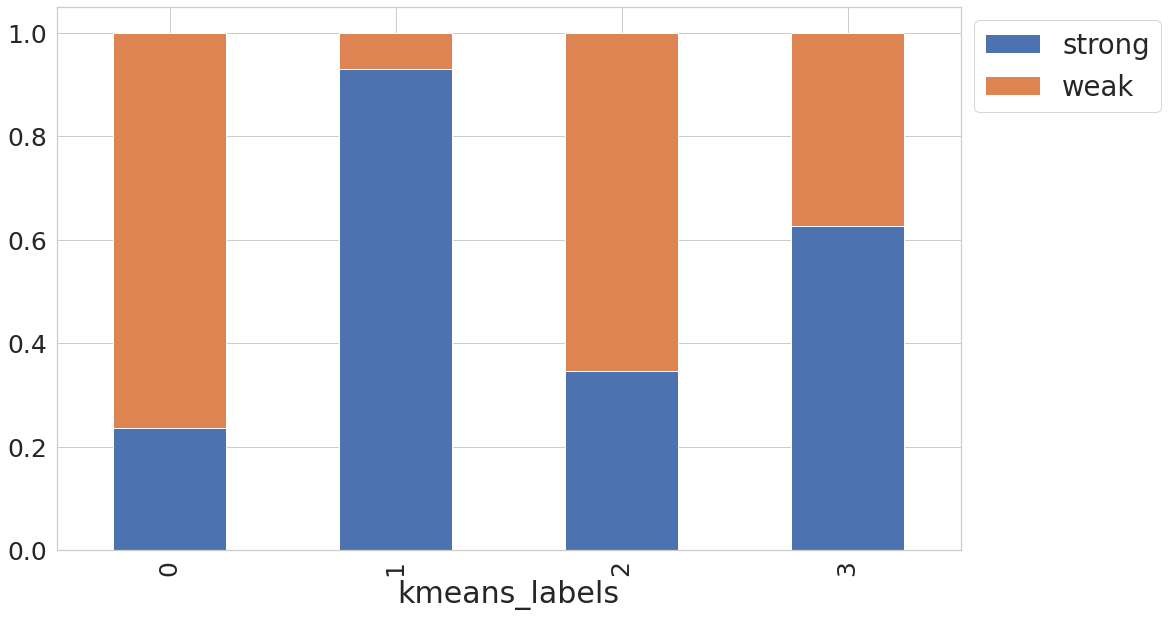

In [ ]:
bar_pl = y_emtype_emph_high.groupby(df_data_emph_high['kmeans_labels']).value_counts(normalize=True).unstack(1)

bar_pl.plot(kind='bar', stacked=True, edgecolor='white', fontsize=25, figsize=(16.2,10))
plt.legend(bbox_to_anchor=(1,1))
plt.savefig("emtype_kmeans_emph_high.svg", format="svg")
plt.show()

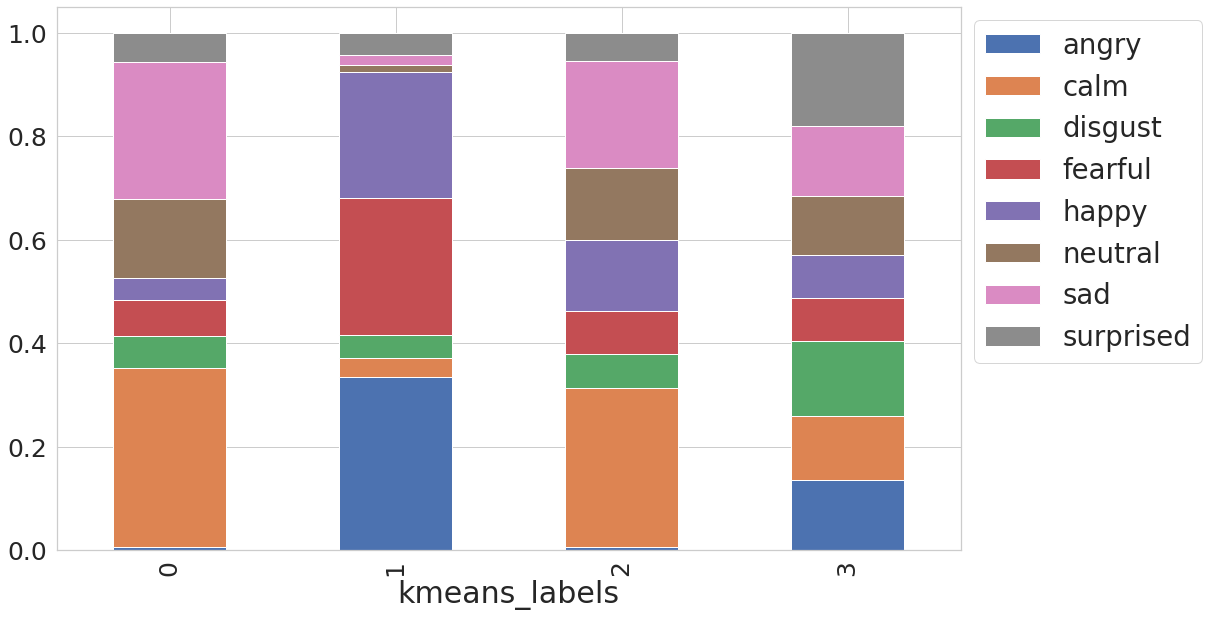

In [ ]:
bar_pl = y_emotion_emph_high.groupby(df_data_emph_high['kmeans_labels']).value_counts(normalize=True).unstack(1)
bar_pl.plot(kind='bar', stacked=True, edgecolor='white', fontsize=25, figsize=(16.2,10))

plt.legend(bbox_to_anchor=(1,1))
plt.savefig("emtoions_kmeans_emph_high.svg", format="svg")
plt.show()

## Low emphasis

In [ ]:
# get KMeans
kmeans = KMeans(n_clusters=4, n_init=100, max_iter=3000, random_state=1)
# fit KMeans
kmeans.fit(X_std_emph_low)

KMeans(max_iter=3000, n_clusters=4, n_init=100, random_state=1)

Text(0.5, 1.0, 'KMeans clustering')

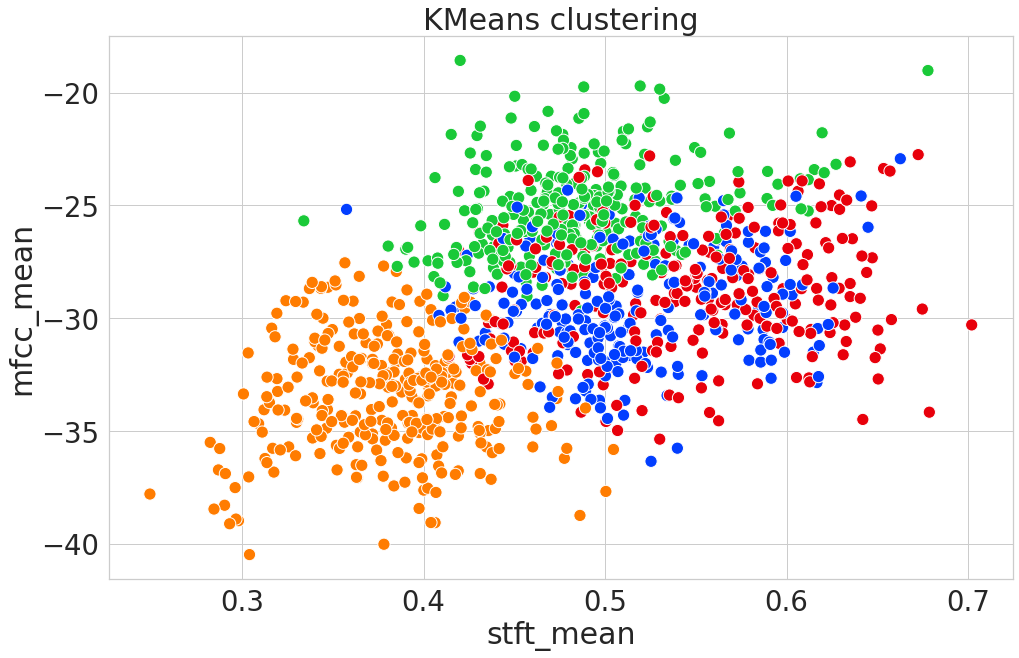

In [ ]:
# Set figure size with matplotlib
plt.figure(figsize=(16.2,10))
sns.set_theme(font_scale=2.5)
sns.set_style("whitegrid")
# Create plot
sns.scatterplot(
    data=df_emph_low, 
    x="stft_mean", 
    y="mfcc_mean", 
    hue=kmeans.labels_,
    palette="bright",
    marker="o",
    s=150,
    legend=False
)
# Set title with matplotlib
plt.title('KMeans clustering')

In [ ]:
centers = kmeans.cluster_centers_
std_scaler.fit(X_emph_low)
centers = std_scaler.inverse_transform(centers)

In [ ]:
df_data_emph_low['kmeans_labels'] = kmeans.labels_

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


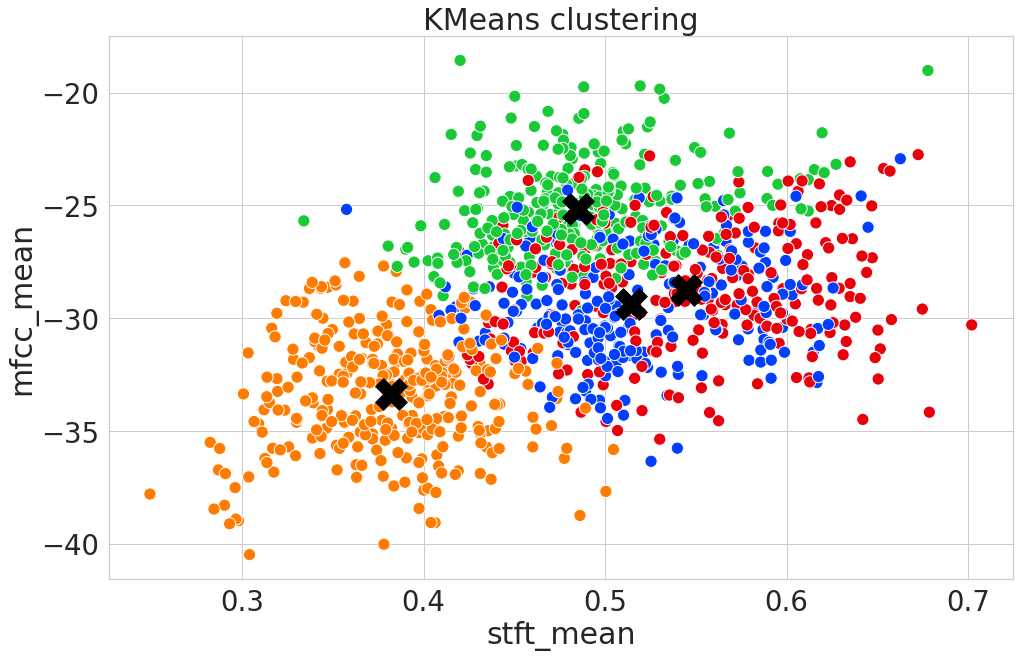

In [ ]:
# Set figure size with matplotlib
plt.figure(figsize=(16.2,10))
sns.set_theme(font_scale=2.5)
sns.set_style("whitegrid")
# Create plot
sns.scatterplot(
    data=df_emph_low, 
    x="stft_mean", 
    y="mfcc_mean", 
    hue=kmeans.labels_,
    palette="bright",
    marker="o",
    s=150,
    legend=False
)
 
# Set title with matplotlib
plt.title('KMeans clustering')
plt.scatter(centers[:,0], centers[:,1], c='black', marker='X', s=1000)
plt.savefig("kmeans_emph_low.svg", format="svg")
plt.show()

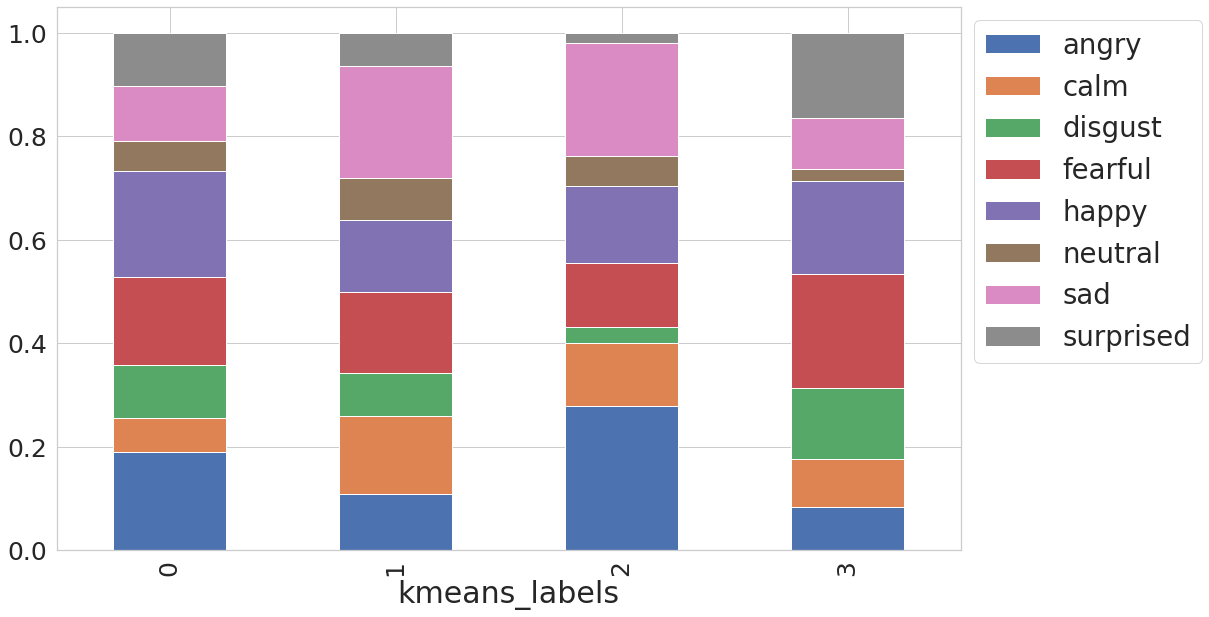

In [ ]:
bar_pl = y_emotion_emph_low.groupby(df_data_emph_low['kmeans_labels']).value_counts(normalize=True).unstack(1)
bar_pl.plot(kind='bar', stacked=True, edgecolor='white', fontsize=25, figsize=(16.2,10))

plt.legend(bbox_to_anchor=(1,1))
plt.savefig("emotions_kmeans_emph_low.svg", format="svg")
plt.show()

# XMeans


In [ ]:
scaler = MinMaxScaler()

In [ ]:
X = scaler.fit_transform(X)

In [ ]:
xm = xmeans.xmeans(X)
xm.process()

In [ ]:
clusters = xm.get_clusters()

In [ ]:
def clusters_to_labels(clusters):
    labels = np.empty(shape=(len(np.concatenate(clusters))), dtype=int)
    for i in range(len(clusters)):
        for idx in clusters[i]:
            labels[idx] = i
    return labels

In [ ]:
labels = clusters_to_labels(clusters)
labels.count()

AttributeError: ignored

In [ ]:
centers = np.array(xm.get_centers())
centers_unscaled = scaler.inverse_transform(centers)

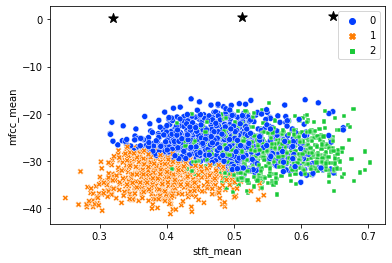

In [ ]:
sns.scatterplot(data=df_data, x="stft_mean", y="mfcc_mean", hue=labels, palette="bright", style=labels)
plt.scatter(centers_unscaled[:, 0], centers_unscaled[:,0], color="black", marker="*", s=100)


## All emphasis

In [90]:
xm = xmeans.xmeans(X_std, kmax = 16)
xm.process()
clusters = xm.get_clusters()

In [91]:
#X_std = scaler.fit_transform(X_std)

In [92]:
def clusters_to_labels(clusters):
    labels = np.empty(shape=(len(np.concatenate(clusters))), dtype=int)
    for i in range(len(clusters)):
        for idx in clusters[i]:
            labels[idx] = i
    return labels

In [93]:
labels = clusters_to_labels(clusters)
df_data['xmeans_labels'] = labels
df_data.groupby("xmeans_labels").count()

,length_ms,intensity,zero_crossings_sum,mfcc_mean,mfcc_max,sc_mean,sc_std,sc_min,sc_max,sc_kur,stft_mean,stft_std,stft_min,stft_kur,mean,kur,skew
xmeans_labels,,,,,,,,,,,,,,,,,
0,113,113,113,113,113,113,113,113,113,113,113,113,113,113,113,113,113
1,140,140,140,140,140,140,140,140,140,140,140,140,140,140,140,140,140
2,171,171,171,171,171,171,171,171,171,171,171,171,171,171,171,171,171
3,147,147,147,147,147,147,147,147,147,147,147,147,147,147,147,147,147
4,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151
5,112,112,112,112,112,112,112,112,112,112,112,112,112,112,112,112,112
6,193,193,193,193,193,193,193,193,193,193,193,193,193,193,193,193,193
7,118,118,118,118,118,118,118,118,118,118,118,118,118,118,118,118,118
8,129,129,129,129,129,129,129,129,129,129,129,129,129,129,129,129,129


In [94]:
sil_score = silhouette_score(X_std, labels)
print("sil", sil_score)
xm.get_total_wce()

sil 0.10248403992622629


19879.486121530474

Text(0.5, 1.0, 'XMeans Clustering')

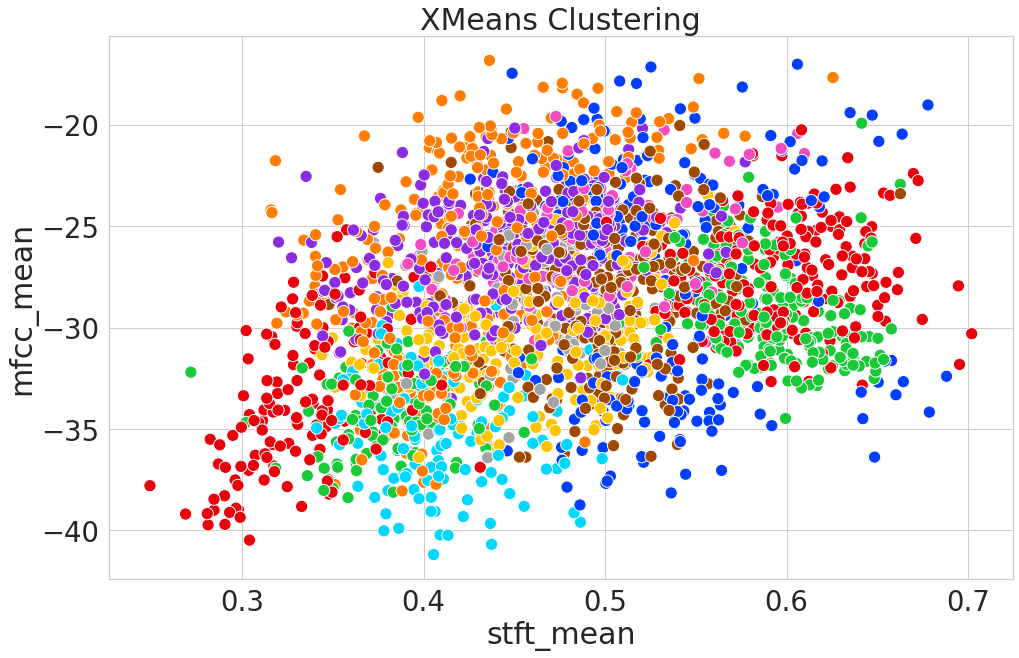

In [86]:
# Set figure size with matplotlib
plt.figure(figsize=(16.2,10))
sns.set_theme(font_scale=2.5)
sns.set_style("whitegrid")
# Create plot
sns.scatterplot(
    data=df, 
    x="stft_mean", 
    y="mfcc_mean", 
    hue=labels,
    palette="bright",
    marker="o",
    s=150,
    legend=False
)
# Set title with matplotlib
plt.title('XMeans Clustering')

In [ ]:
centers = np.array(xm.get_centers())
centers_unscaled = std_scaler.inverse_transform(centers)

Text(0.5, 1.0, 'XMeans clustering')

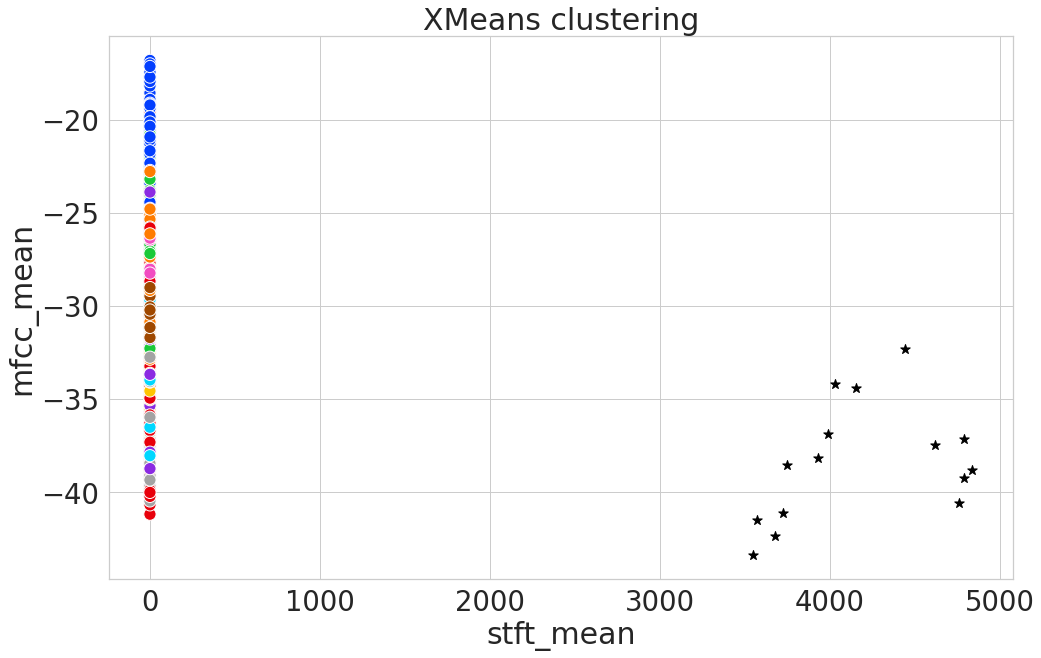

In [ ]:
# Set figure size with matplotlib
plt.figure(figsize=(16.2,10))
sns.set_theme(font_scale=2.5)
sns.set_style("whitegrid")
# Create plot
sns.scatterplot(
    data=df, 
    x="stft_mean", 
    y="mfcc_mean", 
    hue=labels,
    palette="bright",
    marker="o",
    s=150,
    legend=False
)
# Set title with matplotlib
plt.scatter(centers_unscaled[:, 0], centers_unscaled[:,1], color="black", marker="*", s=100)
plt.title('XMeans clustering')

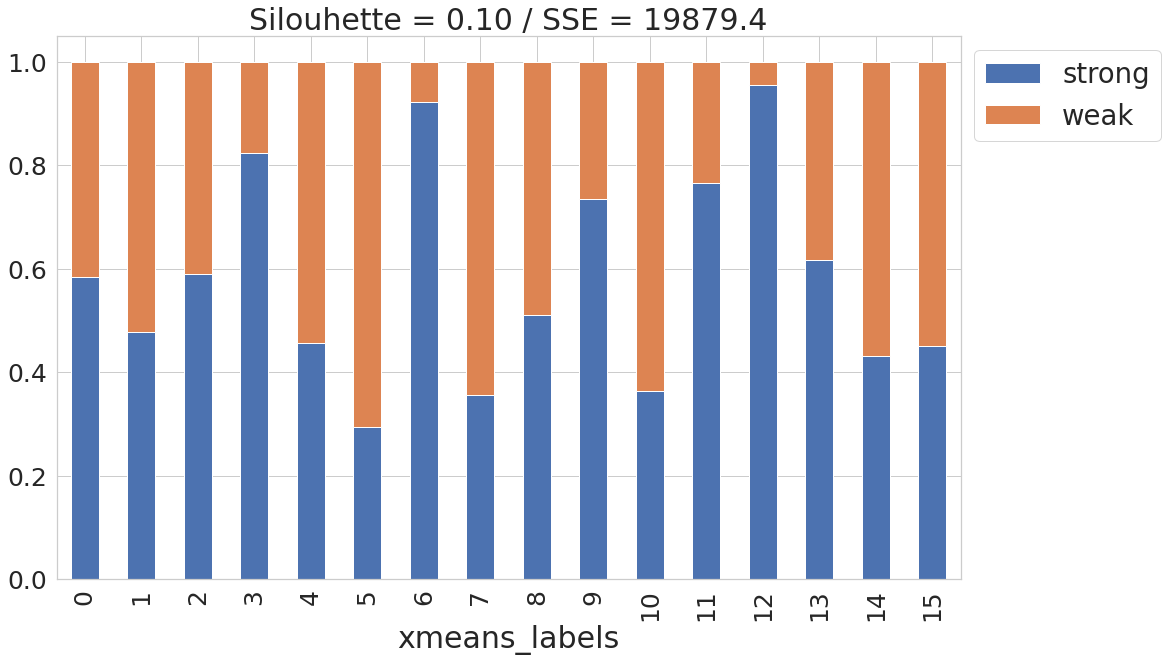

In [95]:
bar_pl = y_emtype.groupby(df_data['xmeans_labels']).value_counts(normalize=True).unstack(1)

bar_pl.plot(kind='bar', stacked=True, edgecolor='white', fontsize=25, figsize=(16.2,10))
plt.legend(bbox_to_anchor=(1,1))
plt.savefig("emtype_kmeans_all.svg", format="svg")
plt.title("Silouhette = 0.10 / SSE = 19879.4")
plt.show()

## High emphasis

In [114]:
xm = xmeans.xmeans(X_std_emph_high, kmax=16)
xm.process()
clusters = xm.get_clusters()


In [115]:
def clusters_to_labels(clusters):
    labels = np.empty(shape=(len(np.concatenate(clusters))), dtype=int)
    for i in range(len(clusters)):
        for idx in clusters[i]:
            labels[idx] = i
    return labels

In [116]:
labels = clusters_to_labels(clusters)
df_data_emph_high['xmeans_labels'] = labels
df_data_emph_high.groupby("xmeans_labels").count()

,length_ms,intensity,zero_crossings_sum,mfcc_mean,mfcc_max,sc_mean,sc_std,sc_min,sc_max,sc_kur,stft_mean,stft_std,stft_min,stft_kur,mean,kur,skew
xmeans_labels,,,,,,,,,,,,,,,,,
0,118,118,118,118,118,118,118,118,118,118,118,118,118,118,118,118,118
1,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150
2,158,158,158,158,158,158,158,158,158,158,158,158,158,158,158,158,158
3,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127
4,119,119,119,119,119,119,119,119,119,119,119,119,119,119,119,119,119
5,176,176,176,176,176,176,176,176,176,176,176,176,176,176,176,176,176
6,112,112,112,112,112,112,112,112,112,112,112,112,112,112,112,112,112
7,146,146,146,146,146,146,146,146,146,146,146,146,146,146,146,146,146
8,212,212,212,212,212,212,212,212,212,212,212,212,212,212,212,212,212


In [117]:
sil_score = silhouette_score(X_std_emph_high, labels)
print("SIL", sil_score)
xm.get_total_wce()

SIL 0.12876775590331443


12075.097027799122

In [118]:
centers = np.array(xm.get_centers())
centers_unscaled = std_scaler.inverse_transform(centers)

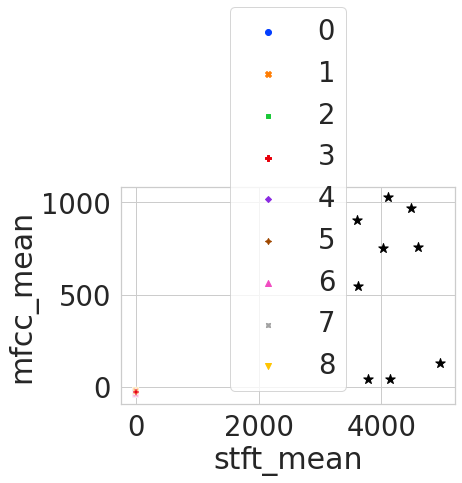

In [119]:
sns.scatterplot(data=df_data_emph_high, x="stft_mean", y="mfcc_mean", hue=labels, palette="bright", style=labels)
plt.scatter(centers_unscaled[:, 0], centers_unscaled[:,7], color="black", marker="*", s=100)

In [121]:
labels = clusters_to_labels(clusters)
df_data_emph_high['xmeans_labels'] = labels
df_data_emph_high.groupby("xmeans_labels").count()

,length_ms,intensity,zero_crossings_sum,mfcc_mean,mfcc_max,sc_mean,sc_std,sc_min,sc_max,sc_kur,stft_mean,stft_std,stft_min,stft_kur,mean,kur,skew
xmeans_labels,,,,,,,,,,,,,,,,,
0,118,118,118,118,118,118,118,118,118,118,118,118,118,118,118,118,118
1,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150
2,158,158,158,158,158,158,158,158,158,158,158,158,158,158,158,158,158
3,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127
4,119,119,119,119,119,119,119,119,119,119,119,119,119,119,119,119,119
5,176,176,176,176,176,176,176,176,176,176,176,176,176,176,176,176,176
6,112,112,112,112,112,112,112,112,112,112,112,112,112,112,112,112,112
7,146,146,146,146,146,146,146,146,146,146,146,146,146,146,146,146,146
8,212,212,212,212,212,212,212,212,212,212,212,212,212,212,212,212,212


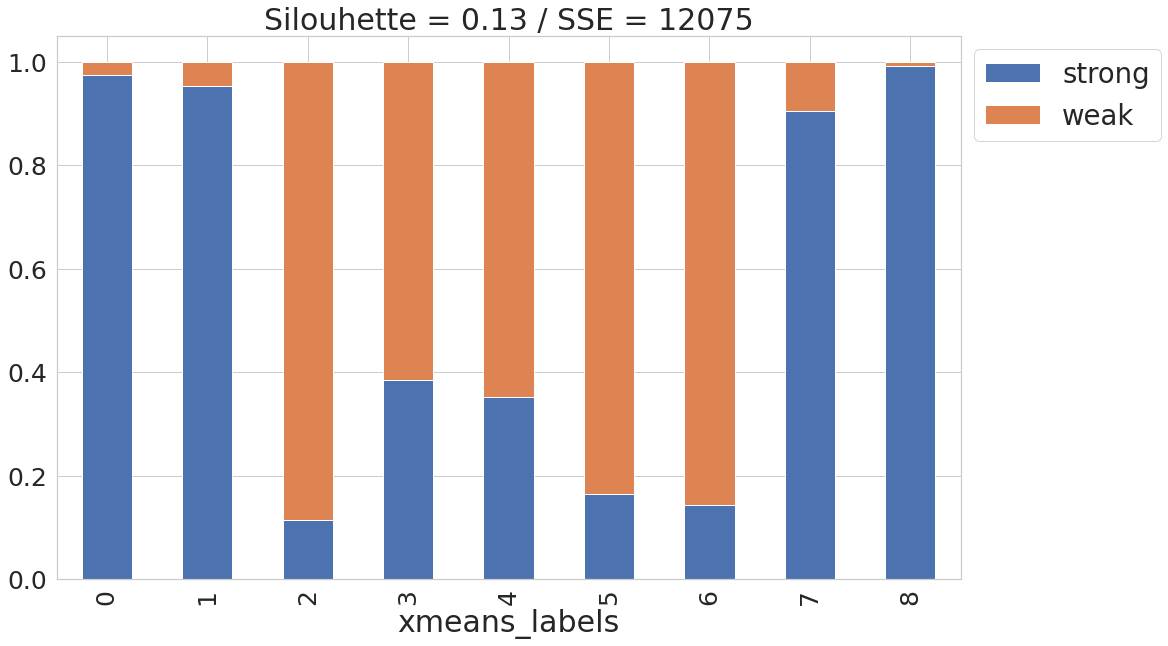

In [124]:
bar_pl = y_emtype_emph_high.groupby(df_data_emph_high['xmeans_labels']).value_counts(normalize=True).unstack(1)

bar_pl.plot(kind='bar', stacked=True, edgecolor='white', fontsize=25, figsize=(16.2,10))
plt.legend(bbox_to_anchor=(1,1))
plt.savefig("emtype_kmeans_all.svg", format="svg")
plt.title("Silouhette = 0.13 / SSE = 12075")
plt.show()

## Low emphasis

In [106]:
xm = xmeans.xmeans(X_std_emph_low)
xm.process()
clusters = xm.get_clusters()


In [107]:
def clusters_to_labels(clusters):
    labels = np.empty(shape=(len(np.concatenate(clusters))), dtype=int)
    for i in range(len(clusters)):
        for idx in clusters[i]:
            labels[idx] = i
    return labels

In [108]:
labels = clusters_to_labels(clusters)

In [109]:
centers = np.array(xm.get_centers())
centers_unscaled = std_scaler.inverse_transform(centers)

In [110]:
sil_score = silhouette_score(X_std_emph_low, labels)
print("SIL", sil_score)
xm.get_total_wce()

SIL 0.12192474700611264


11593.275207234543

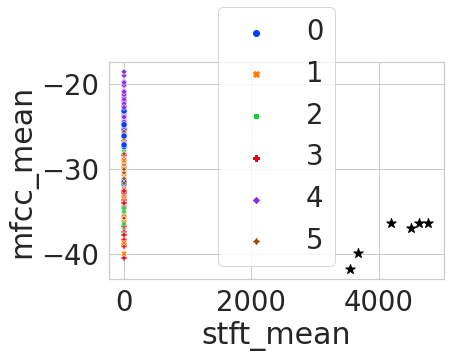

In [111]:
sns.scatterplot(data=df_data_emph_low, x="stft_mean", y="mfcc_mean", hue=labels, palette="bright", style=labels)
plt.scatter(centers_unscaled[:, 0], centers_unscaled[:,1], color="black", marker="*", s=100)

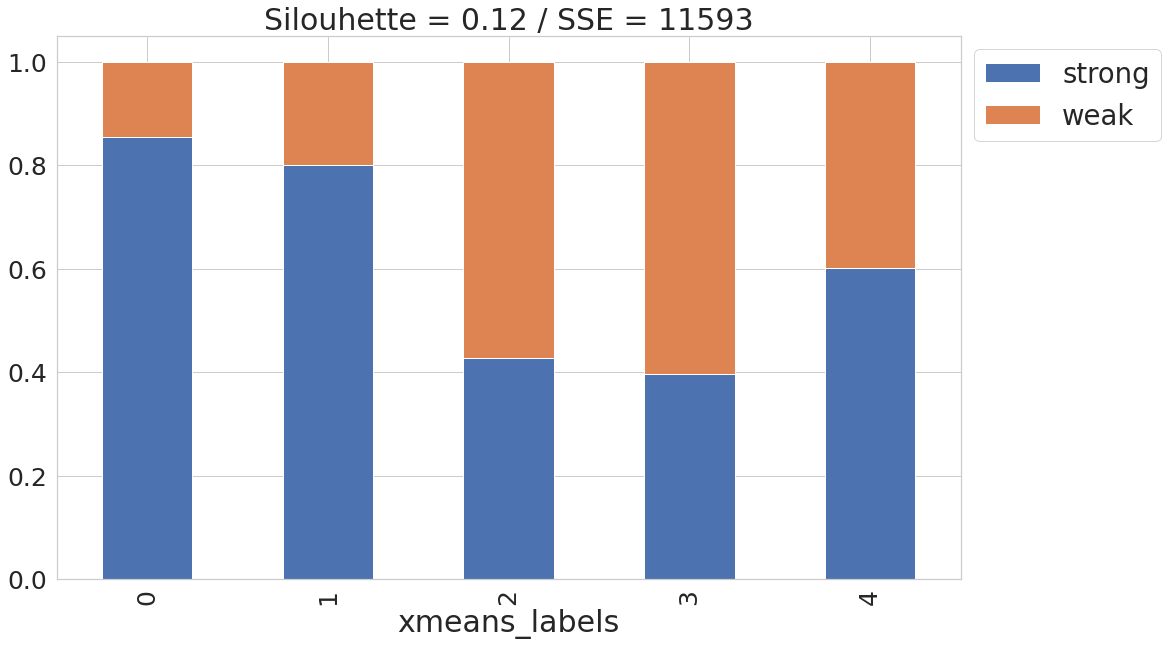

In [113]:
bar_pl = y_emtype_emph_low.groupby(df_data_emph_low['xmeans_labels']).value_counts(normalize=True).unstack(1)

bar_pl.plot(kind='bar', stacked=True, edgecolor='white', fontsize=25, figsize=(16.2,10))
plt.legend(bbox_to_anchor=(1,1))
plt.savefig("emtype_kmeans_all.svg", format="svg")
plt.title("Silouhette = 0.12 / SSE = 11593")
plt.show()

# Bisecting K-MEANS

In [ ]:
from sklearn.cluster import BisectingKMeans

SyntaxError: ignored

In [ ]:
bkmeans = BisectingKMeans(n_clusters=8)
bkmeans.fit(X)

NameError: ignored

<AxesSubplot:xlabel='mean radius', ylabel='mean concave points'>

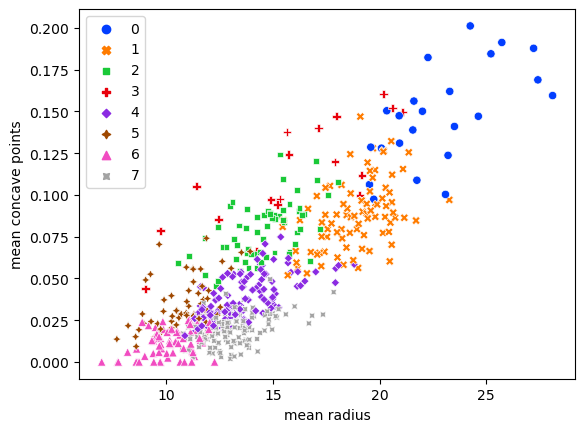

In [ ]:
sns.scatterplot(data=df, x="mean radius", y="mean concave points", hue=bkmeans.labels_, 
                palette="bright", style=bkmeans.labels_)

#### Silhouette plot

In [ ]:
# !pip install yellowbrick

In [ ]:
from yellowbrick.cluster import SilhouetteVisualizer

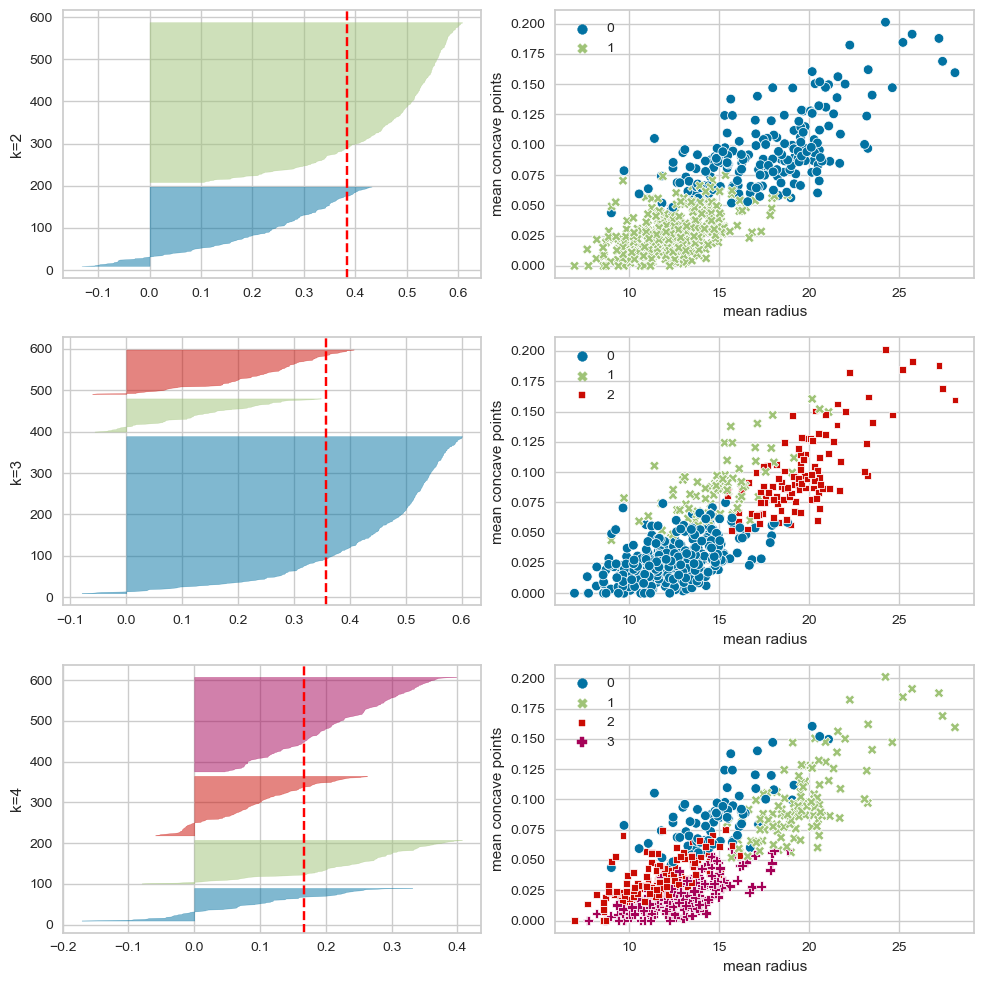

In [ ]:
colors=['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']
n_clust = 5
fig, axs = plt.subplots(n_clust-2, 2, figsize=(10,10))
for i in range(2, n_clust):
    bkmeans = BisectingKMeans(n_clusters=i)
    visualizer = SilhouetteVisualizer(bkmeans, colors=colors, ax=axs[i-2][0])
    axs[i-2][0].set_ylabel("k=" + str(i))
    visualizer.fit(X)
    sns.scatterplot(data=df, x="mean radius", y="mean concave points", hue=bkmeans.labels_, 
                    palette=sns.color_palette(colors[:i]), style=bkmeans.labels_, ax=axs[i-2][1])
plt.tight_layout()

In [ ]:
silhouette_score(X, bkmeans.labels_)

0.16723675902218899